<a href="https://colab.research.google.com/github/Bernat-Jorda-Carbonell/TDA_projects/blob/main/circular_coordinates/TDA_circular_coordinates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Warm Up.
We will start by importing the packages used. The first line is commented to not reinstall ripser every time.

In [317]:
# uncomment if not installed
#!pip install ripser
#!pip install openml

import os
import urllib.request
import zipfile
import natsort
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from openml.datasets.functions import get_dataset
import matplotlib as mpl

# this is to fix a "no tex found" problem that was rising up and a link to where I found the fix
# https://stackoverflow.com/questions/58121461/runtimeerror-failed-to-process-string-with-tex-because-latex-could-not-be-found
mpl.rcParams.update(mpl.rcParamsDefault)




## Sample Data: Noisy Circle and Ripser **Computation**



Code from an example in ripser documentation, just the functions defined

In [318]:
# from https://ripser.scikit-tda.org/en/latest/notebooks/Representative%20Cocycles.html

def drawLineColored(X, C):
    """
    Draw a colored line by plotting segments between consecutive points.
    """
    for i in range(X.shape[0]-1):
        plt.plot(X[i:i+2, 0], X[i:i+2, 1], c=C[i, :], linewidth = 3)

def plotCocycle2D(D, X, cocycle, thresh):
    """
    Given a 2D point cloud X, display the cocycle projected onto edges under a given threshold.
    Edges with length <= thresh are drawn, then the cocycle values are added as text.
    """
    #Plot all edges under the threshold
    N = X.shape[0]
    t = np.linspace(0, 1, 10)
    c = plt.get_cmap('Greys')
    C = c(np.array(np.round(np.linspace(0, 255, len(t))), dtype=np.int32))
    C = C[:, 0:3]

    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                Y = np.zeros((len(t), 2))
                Y[:, 0] = X[i, 0] + t*(X[j, 0] - X[i, 0])
                Y[:, 1] = X[i, 1] + t*(X[j, 1] - X[i, 1])
                drawLineColored(Y, C)
    #Plot cocycle projected to edges under the chosen threshold
    for k in range(cocycle.shape[0]):
        [i, j, val] = cocycle[k, :]
        if D[i, j] <= thresh:
            [i, j] = [min(i, j), max(i, j)]
            a = 0.5*(X[i, :] + X[j, :])
            plt.text(a[0], a[1], '%g'%val, color='b')
    #Plot vertex labels
    for i in range(N):
        plt.text(X[i, 0], X[i, 1], '%i'%i, color='r')
    plt.axis('equal')

Instead of the 12 points in a noisy circle, we use the code to sample 20 points from the circle

In [319]:
np.random.seed(9)
N = 20
t_vals = np.linspace(0, 2*np.pi, N, endpoint=False)
# Sample points from a circle with noise.
x_circle = np.transpose([np.cos(t_vals), np.sin(t_vals)]) + 0.4 * np.random.random((N, 2))


And we run ripser, turning on a flag that indicates that we want to store the cocycles, and doing the computation over the field $\mathbb{Z}_{17}$ as it does in the ripser example (it is a better idea to change "coeff" value from 17 to 41)

In [320]:
result_circle = ripser(x_circle, coeff=17, do_cocycles=True)
diagrams_circle = result_circle['dgms']
cocycles_circle = result_circle['cocycles']
D_circle = result_circle['dperm2all']

Now find the index of the maximum persistence point in the diagram and highlight that point with a black x. This is the point of which we are asked to project the representative cocycle.

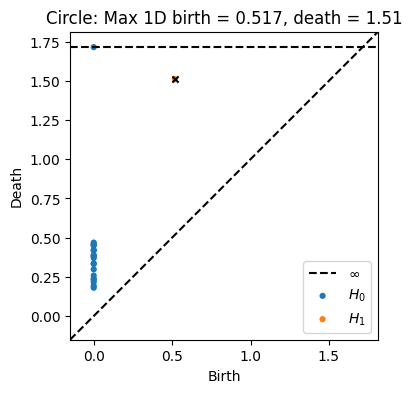

In [321]:
diagram1_circle = diagrams_circle[1]
max_idx_circle = np.argmax(diagram1_circle[:, 1] - diagram1_circle[:, 0])
plt.figure(figsize=(6,4))
plot_diagrams(diagrams_circle, show=False)
plt.scatter(diagram1_circle[max_idx_circle, 0], diagram1_circle[max_idx_circle, 1],
            20, c='k', marker='x')
plt.title("Circle: Max 1D birth = %.3g, death = %.3g" % (diagram1_circle[max_idx_circle, 0],
                                                        diagram1_circle[max_idx_circle, 1]))
plt.show()

## Comparation of cocycles before death and after birth


we will jumpt to the code of the example that project the representative cocycle of that point onto the edges present *right before* the feature vanishes. (we moved the line of code where it defines cocycle from the part of code that we don't use to here)

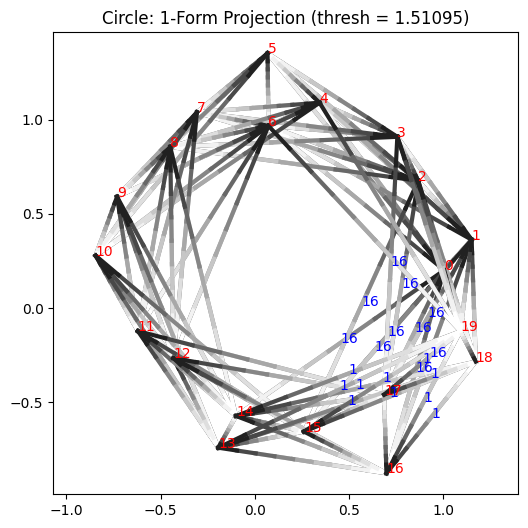

In [322]:
# Get representative cocycle.
cocycle_circle = cocycles_circle[1][max_idx_circle]
# Threshold just before death.
thresh_circle_before = diagram1_circle[max_idx_circle, 1] - 1e-8
plt.figure(figsize=(6,6))
plotCocycle2D(D_circle, x_circle, cocycle_circle, thresh_circle_before)
plt.title("Circle: 1-Form Projection (thresh = %g)" % thresh_circle_before)
plt.show()

Now we will project onto the edges present right after its birth

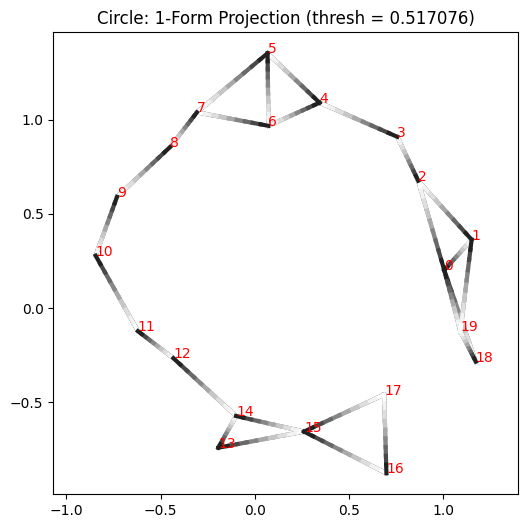

In [323]:
thresh_circle_birth = diagram1_circle[max_idx_circle, 0]
plt.figure(figsize=(6,6))
plotCocycle2D(D_circle, x_circle, cocycle_circle, thresh_circle_birth)
plt.title("Circle: 1-Form Projection (thresh = %g)" % thresh_circle_birth)
plt.show()

#Implementation
Now we are going to go over the 7 steps of the algorithm. Since the implementation asks for distance matrix $D$, cocycle $\alpha$, a treshold $r$ and a prime $p$, we conclude that step 2 has to be computed beforehand and we can use the ripser example to get the first 3 steps.

 We will start by defining function for every step. The first ones may vary, so we will make a default option (most persistent point of the diagram, $r=$ just before the dead of the feature).

In [324]:
def persistent_cohomology(D, p=41):
    """Compute persistent cohomology on a distance matrix D with coefficients in Z_p."""
    return ripser(D, coeff=p, distance_matrix=True, do_cocycles=True)

In [325]:
def maximum_persistence_cocycle(D, p=41):
    """Return the cocycle corresponding to the most persistent H1 feature."""
    ph = persistent_cohomology(D, p)
    diagram1_ph = ph['dgms'][1]
    idx_ph = np.argmax(diagram1_ph[:, 1] - diagram1_ph[:, 0])
    return ph['cocycles'][1][idx_ph]

In [434]:
def default_threshold(D, p=41):
    """Return a default threshold (just after birth) for the most persistent H1 feature."""
    ph = persistent_cohomology(D, p)
    diagram1_ph = ph['dgms'][1]
    idx_ph = np.argmax(diagram1_ph[:, 1] - diagram1_ph[:, 0])
    return diagram1_ph[idx_ph, 1] - 1e-8

Now, we will define the functions to project the cocycle to the edges. To do that, we run into the first problem: ripser gives the cocyles as an array of edges with values, but only the edges with values different than $0$. So we will start by making an array of all the edges that are under the distance treshold.

In [327]:
def getEdges(D, r):
    """
    Return a list of all edges (as (i, j)) with distance <= r.
    Only the upper triangular part is considered.
    """
    edges = []
    N = D.shape[0]
    for i in range(N):
        for j in range(i+1, N):
            if D[i, j] <= r:
                edges.append((i, j))
    return edges

Now we define a function that merge the cocycle array and the edges array. Basically, for every edge, look at the cocyle and asign it the value that the cocycle assigns it. If the edge is not in the cocyle array, assign a value of 0.

In [328]:
def mergeArrays(all_edges, cocycle_edges, p):
    """
    Merge the complete edge list with the cocycle's nonzero edge values.
    For each edge in all_edges, assign the cocycle value if present (adjusting modulo p), else 0.
    """
    merged = []
    for (i, j) in all_edges:
        value = 0
        for edge in cocycle_edges:
            if (i, j) == (edge[0], edge[1]):
                value = edge[2]
                break
            if (i, j) == (edge[1], edge[0]):
                value = p - edge[2]
                break
        merged.append((i, j, value))
    return np.array(merged)

we continue by defining a function that lifts $α_r$ to a cocycle $\hat{\alpha_r}$ (using equation $(2)$).

In [329]:
def lifting(A, p):
    """
    Lift a cocycle array A by adjusting values greater than (p-1)/2.
    """
    threshold_val = (p - 1) / 2
    for i in range(A.shape[0]):
        if A[i, 2] > threshold_val:
            A[i, 2] = A[i, 2] - p
    return A

Now we define a function to represent the coboundary oberator in the basis given by the simplices. We use the fact that it is the transpose of the boundary matrix to compute it directly (just changing rows and columns to the normal algorithm). Doing the Moore-Penrose pseudoinvers is going to be done in the main implementation.

In [330]:
def coboundary_operator(D, A):
    """
    Construct the coboundary operator as a matrix.
    Rows correspond to edges (from A) and columns to vertices.
    """
    num_edges = A.shape[0]
    num_vertices = D.shape[0]
    B = np.zeros((num_edges, num_vertices))
    for n in range(num_edges):
        B[n, A[n, 0]] = -1
        B[n, A[n, 1]] = 1
    return B

Now we use the defined functions to make the final implementation. We assign default values of False to cocyle and r so, if not especified, it uses the maximum persistence point and $r≃y$ (just before the death of the feature). It generates an array with the edges $v_iv_j$ such that $d(v_i,v_j)\leq r$. It then projects the cocycle, lifts the results. Rewrite both the Moore-Penrose inverse of the coboundary operator and $\hat{\alpha_r}$. Finally, it returns a vector where each element is the product of the pseudoinverse and - the vector mod $\mathbb{Z}$

In [331]:
def circular_coordinates(D, cocycle=False, r=False, p=41):
    """
    Compute circular coordinates given a distance matrix D, an optional cocycle,
    and a threshold r. If cocycle or r are not provided, defaults (maximum persistence)
    are used.
    """
    if isinstance(cocycle, bool):
        cocycle = maximum_persistence_cocycle(D, p)
    if isinstance(r, bool):
        r = default_threshold(D, p)

    edges_at_r = getEdges(D, r)
    merged_edges = mergeArrays(edges_at_r, cocycle, p)
    lifted_edges = lifting(merged_edges, p)
    B = coboundary_operator(D, lifted_edges)
    mpinv = np.linalg.pinv(B)  # Moore-Penrose pseudoinverse of the coboundary operator
    vec = lifted_edges[:, 2]
    # Return circular coordinates modulo 1.
    return np.dot(mpinv, -vec) % 1

#First Example

Before getting too much into the example per se, lets define a function that plots a scatter that color.codes every point by its circular coordinate.

In [383]:
def plot_circular_coordinates(D, X, cocycle=False, r=False, p=41, norm="linear"):
    """
    Plot a scatter plot of points X, color-coded by their circular coordinates.
    """
    coords = circular_coordinates(D, cocycle, r, p)
    plt.figure(figsize=(6,6))
    plt.scatter(X[:, 0], X[:, 1], c=coords, cmap="plasma", norm=norm)
    plt.title("Circular Coordinates")
    plt.show()


Now we generate our data


In [333]:
N = 100
t_vals = np.linspace(0, 2*np.pi, N, endpoint=False)
x_circle2 = np.transpose([np.cos(t_vals), np.sin(t_vals)]) + 0.2 * np.random.random((N, 2))

We use ripser to get the distance matrix and then we compute and print on screen our circular coordinates of the most persistent point. Since it is the one we defined as defualt, we just have to call the function by default (we could directly plot it using the defined function).


In [334]:
D_circle2 = ripser(x_circle2, coeff=41, do_cocycles=True)['dperm2all']
circ_coords_circle2 = circular_coordinates(D_circle2)
print("Circular Coordinates (circle test sample):", circ_coords_circle2)

Circular Coordinates (circle test sample): [0.41267757 0.40596541 0.40263029 0.38184969 0.39052982 0.37002797
 0.37002797 0.3558157  0.35191667 0.33129018 0.32225978 0.3272026
 0.3272026  0.30334375 0.27969871 0.27151389 0.2642385  0.25514425
 0.25514425 0.24602224 0.23880238 0.21678181 0.1868194  0.19548323
 0.16750627 0.16750627 0.15734024 0.15734024 0.15402727 0.15402727
 0.1308365  0.1436341  0.09426073 0.10823311 0.08816476 0.08426946
 0.07703027 0.07703027 0.05755877 0.06089761 0.04346483 0.04346483
 0.03715949 0.04346483 0.01824346 0.98413693 0.98800664 0.98800664
 0.97482309 0.97482309 0.96091868 0.95304655 0.93434648 0.94433594
 0.92903204 0.88439918 0.85501021 0.85180359 0.85180359 0.846371
 0.84067367 0.80648973 0.83256391 0.79824188 0.79078819 0.79078819
 0.78293867 0.78588255 0.78038814 0.75154307 0.704253   0.704253
 0.67889468 0.68232123 0.66287189 0.6613336  0.65833537 0.65056559
 0.64402283 0.65232363 0.63681249 0.62819968 0.62090431 0.62485892
 0.61439986 0.59338426 0

Finally, we produce the scatter plot

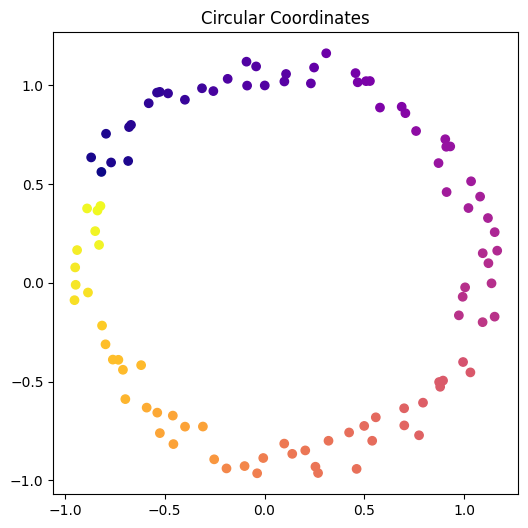

In [335]:
plot_circular_coordinates(D_circle2, x_circle2)

#The Flat Torus

Now, to make a distance function on the flat torus, it is important to understand the quotient... or to do a function that if the distance in one of the axis is greater than $1/2$, go the other way around...

In [336]:
def flat_torus_distance(x, y):
    """
    Compute the distance between two points on the flat torus.
    """
    dx = abs(x[0] - y[0])
    if dx > 0.5:
        dx = 1 - dx
    dy = abs(x[1] - y[1])
    if dy > 0.5:
        dy = 1 - dy
    return np.sqrt(dx**2 + dy**2)

Now that we have defined the distance on the flat torus, it is quite easy to define the distance matrix (quite similar than before, but with a different distance function)

In [337]:
def torus_distance_matrix(X):
    """
    Compute the full distance matrix for points X on the flat torus.
    """
    n = X.shape[0]
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            M[i, j] = flat_torus_distance(X[i], X[j])
    return M

Sample grid on flat torus with noise.

In [338]:
grid_size = 15
t_grid = np.linspace(0, 1, grid_size)
x_grid, y_grid = np.meshgrid(t_grid, t_grid)
x_grid = x_grid.reshape(-1, 1)
y_grid = y_grid.reshape(-1, 1)
X_torus = np.hstack([x_grid, y_grid]) + 0.05 * np.random.random((grid_size**2, 2))

We now recalculate the two most persistence points, by using this new distance matrix and then using ripser again.

In [339]:
D_torus = torus_distance_matrix(X_torus)
ripser_result_torus = ripser(D_torus, coeff=41, do_cocycles=True, distance_matrix=True)
diagrams_torus = ripser_result_torus['dgms']
cocycles_torus = ripser_result_torus['cocycles']
dgm1_torus = diagrams_torus[1]

we can not use np.argmax() as a way to find the two most persistent points (only to find the most persistent one), so we will use np.argsort to sort the persistence of the element of dgm1 and pick the two last ones.





In [340]:
idx1_torus = np.argsort(dgm1_torus[:, 1] - dgm1_torus[:, 0])[-1]
idx2_torus = np.argsort(dgm1_torus[:, 1] - dgm1_torus[:, 0])[-2]
cocycle1_torus = cocycles_torus[1][idx1_torus]
cocycle2_torus = cocycles_torus[1][idx2_torus]

Now, before continuing, let's plot the persistance diagram to check that it has the general Torus structure: two relevant $H_0$ elements

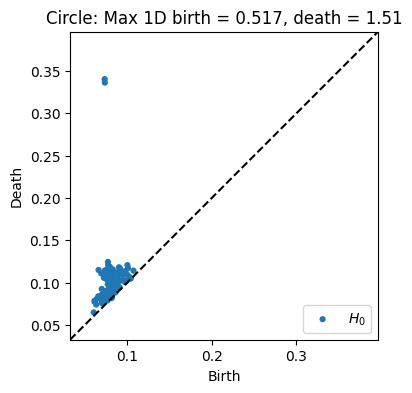

In [371]:
diagram1_torus = diagrams_torus[1]
plt.figure(figsize=(6,4))
plot_diagrams(diagram1_torus, show=False)

plt.title("Circle: Max 1D birth = %.3g, death = %.3g" % (diagram1_circle[max_idx_circle, 0],
                                                        diagram1_circle[max_idx_circle, 1]))
plt.show()

now we plot both circular coordinates and we get exactly what we expect: vertical or horizontal gradient.  After trying with diferent thrsholds I didn't have any problem with any of them as long as they are chosen accordingly (You might pick a treshold just before the colapse of one of the two persistent points for the other and run into the problem that at that treshold, the feature is not alive).

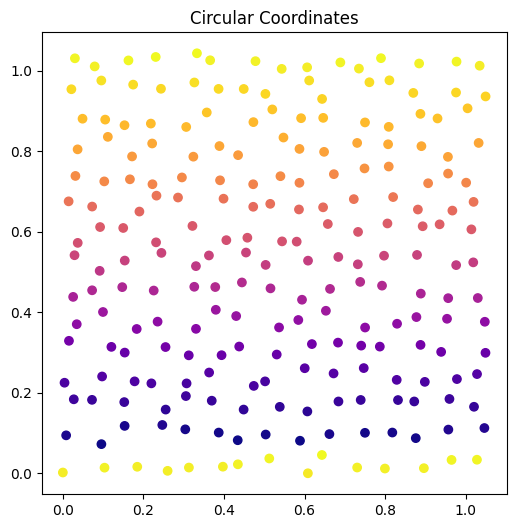

In [341]:
r_torus1 = dgm1_torus[idx1_torus, 1] - 1e-9
plot_circular_coordinates(D_torus, X_torus, cocycle1_torus, r_torus1)

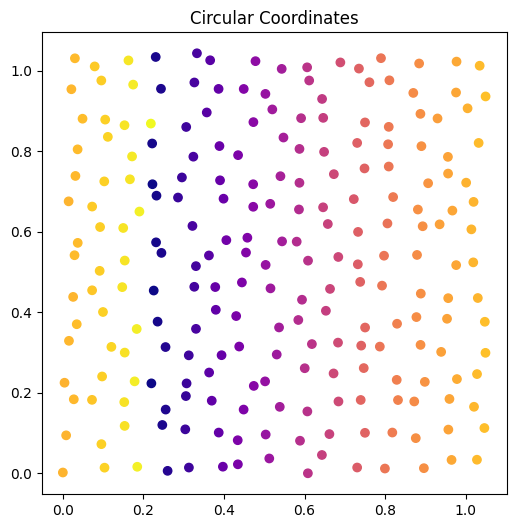

In [342]:
r_torus2 = dgm1_torus[idx2_torus, 1] - 1e-6
plot_circular_coordinates(D_torus, X_torus, cocycle2_torus, r_torus2)



Apart from that, after dealing a bunch of testing, it really seems like that if you chose any treshold in which the feature is alive, the circular coordiantes doesn't vary much. Moreover, I did a little bit of research (to rest asure I was not mistaken) and I found evidence on the literature of this result ( [Generalized penalty for circular coordinate representation](https://arxiv.org/pdf/2006.02554.pdf), by Luo, Hengrui and Patania, Alice and Kim, Jisu and Vejdemo-Johansson, Mikael, appendix E).

It should be noticed that sometimes, instead of an horizontal and a vertical gradient, one of the two plots is a diagonal gradient, this is because, for some reason, the base chosen is diagonal. In sight, it still makes sense, it would be as if, when going around the torus per the long side, for some reason the first path to appear goes around the torus in the other direction.

#Image Data
After downloaded and uploaded the unprocessed version (I put in a drive for easy acces), I decided to go with the duck (I just like ducks) then I realised that is not on the unprocessed version, so I just picked the one with the most "intereseting" persistent features (I ploted a persistence diagram with ripser for each and picked obj 1 that had an intereseting feature on circular coordinates). To start, we need to be able to convert the images into vectors of pixel intensities. For that we use the PIL package.

First, lets import the packages and the data

In [343]:
data_url = "https://cave.cs.columbia.edu/old/databases/SLAM_coil-20_coil-100/coil-20/coil-20-unproc.zip"
extract_dir = "./data/"
zip_path, _ = urllib.request.urlretrieve(data_url)
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_dir)

data_directory = "./data/coil-20-unproc/"

Now continue by getting the names of the files, getting only the files of object 1 (or any other one), and getting the images and the vectors of those images in their respective arrays.

In [344]:
# Get file names for object 1 (change "obj1" to "objX" for different objects)
file_names_obj1 = natsort.natsorted([fname for fname in os.listdir(data_directory) if fname.startswith("obj1")])

# Process images: store the PIL image in imgs_obj1 and its flattened pixel vector in X_img_obj1.
X_img_obj1 = []
imgs_obj1 = []
for fname in file_names_obj1:
    path = os.path.join(data_directory, fname)
    image = Image.open(path)
    imgs_obj1.append(image)
    x_im = np.array(image)
    X_img_obj1.append(x_im.reshape(-1))
X_img_obj1 = np.array(X_img_obj1)

We repeat the good all process of running ripser with the vector of the images as the points, and getting the diagrams, cocycles and distance matrix

In [345]:
image_rips_obj1 = ripser(X_img_obj1, do_cocycles=True)
diagrams_img_obj1 = image_rips_obj1['dgms']
cocycles_img_obj1 = image_rips_obj1['cocycles']
D_img_obj1 = image_rips_obj1['dperm2all']

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


We compute the persistence diagram (we have used it to see that there is, in fact, a persistent enough feature to be interesting)

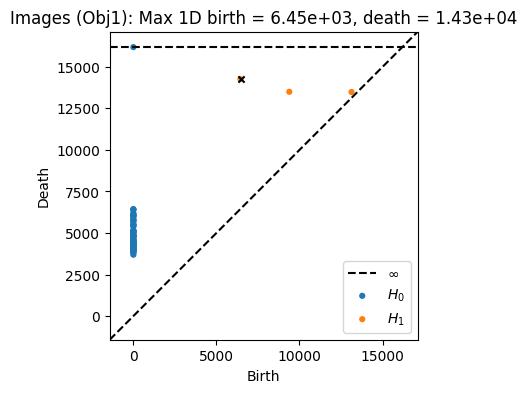

In [346]:
dgm1_img_obj1 = diagrams_img_obj1[1]
max_idx_img_obj1 = np.argmax(dgm1_img_obj1[:, 1] - dgm1_img_obj1[:, 0])
plt.figure(figsize=(6,4))
plot_diagrams(diagrams_img_obj1, show=False)
plt.scatter(dgm1_img_obj1[max_idx_img_obj1, 0], dgm1_img_obj1[max_idx_img_obj1, 1],
            20, c='k', marker='x')
plt.title("Images (Obj1): Max 1D birth = %.3g, death = %.3g" %
          (dgm1_img_obj1[max_idx_img_obj1, 0], dgm1_img_obj1[max_idx_img_obj1, 1]))
plt.show()

Now we will produce a plot with the circular coordinates, we first get the circular coordinates of every image, since we sorted the images beforehand we don't need to swap any order. Then we plot every single image with the circular coordiantes as the title so one can see that in fact, the algorithm understand that the images are "points around the hole", as intended.

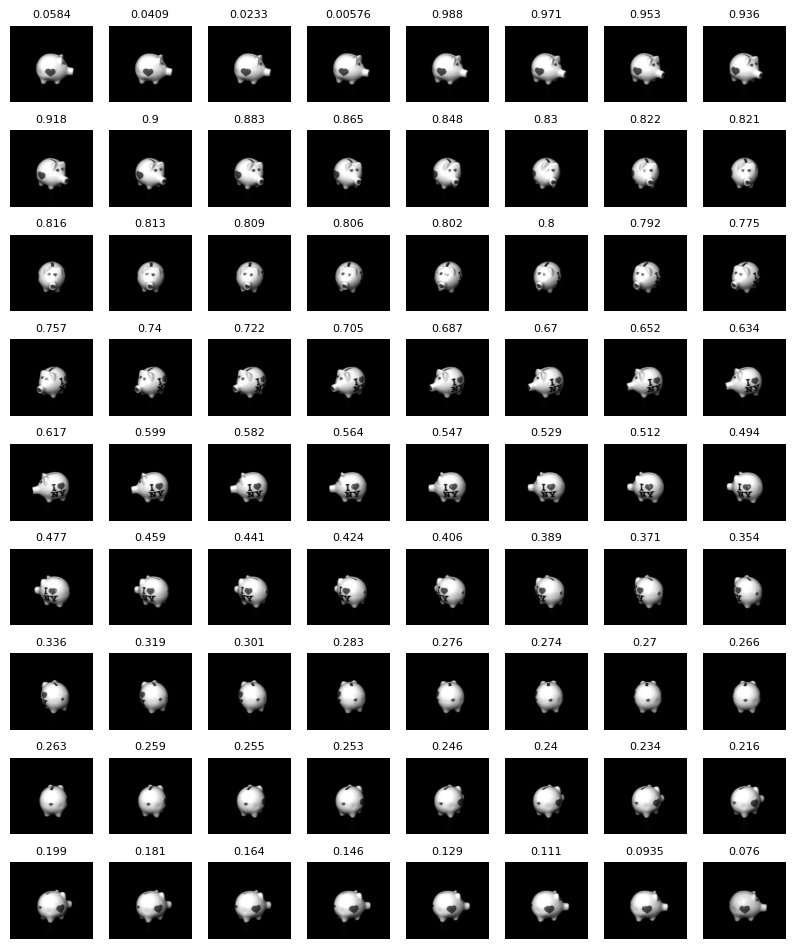

In [347]:
# Compute circular coordinates for every image (using your circular_coordinates function)
cc_img_obj1 = circular_coordinates(D_img_obj1)

# Plot a grid of images with their circular coordinate values as titles
fig, axs = plt.subplots(9, 8, figsize=(10, 12))
for i in range(9):
    for j in range(8):
        idx = i * 8 + j
        if idx < len(imgs_obj1):
            axs[i, j].imshow(imgs_obj1[idx], cmap="gray")
            cc_text = "{:.3g}".format(cc_img_obj1[idx])
            axs[i, j].set_title(cc_text, fontsize=8)
            axs[i, j].axis("off")
plt.show()

As we can see, this image in particular goes back and forth in circular coordiantes, and this is because the front and the back of the piggy look quite similar, so even if the rotation of the camera is at very different angles, the position as the images as vectors in relation to the "hole" in between of the 72 images, is quite close. This is even more evident on the next part, when we perform the PAC to the points and see that some of them are more like an eight than a circle.

##Image Data 2: All images simultaneously

Now we have to et back not only the 72 images of our object but the 72 images of every one of the 5 objects. We basically repeat the same code, but not filtering which elements we get.

In [348]:
file_names_all = natsort.natsorted(os.listdir(data_directory))

X_img_all = []
imgs_all = []
for fname in file_names_all:
    path = os.path.join(data_directory, fname)
    image = Image.open(path)
    imgs_all.append(image)
    x_im = np.array(image)
    X_img_all.append(x_im.reshape(-1))
X_img_all = np.array(X_img_all)

Now we compute ripser to get distance matrix and the persistence diagram

In [349]:
image_rips_all = ripser(X_img_all, do_cocycles=True)
diagrams_img_all = image_rips_all['dgms']
cocycles_img_all = image_rips_all['cocycles']
D_img_all = image_rips_all['dperm2all']

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


We plot the persistence diagram. Always nice to know what is going on and to check that we get the correct values.

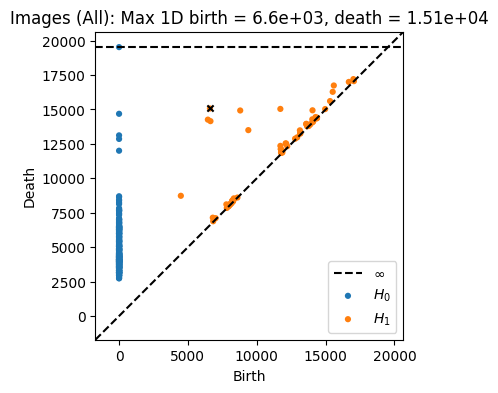

In [350]:
dgm1_img_all = diagrams_img_all[1]
max_idx_img_all = np.argmax(dgm1_img_all[:, 1] - dgm1_img_all[:, 0])
plt.figure(figsize=(6,4))
plot_diagrams(diagrams_img_all, show=False)
plt.scatter(dgm1_img_all[max_idx_img_all, 0], dgm1_img_all[max_idx_img_all, 1],
            20, c='k', marker='x')
plt.title("Images (All): Max 1D birth = %.3g, death = %.3g" %
          (dgm1_img_all[max_idx_img_all, 0], dgm1_img_all[max_idx_img_all, 1]))
plt.show()

We then get the 5 pairs $(x,y)$ that maximise the value of $\frac{y-x}{x}$ with argsort. Now features has the 5 indices in diagrams that are important. We then use this 5 elements to calculate 5 cocycles and the 5 different circular coordinates

In [351]:
# Select the 5 most interesting features (maximizing (death-birth)/birth)
features_img = np.argsort((dgm1_img_all[:, 1] - dgm1_img_all[:, 0]) / dgm1_img_all[:, 0])[-5:]

# Compute 5 cocycles and their circular coordinates
cocycle1_img = cocycles_img_all[1][features_img[0]]
cocycle2_img = cocycles_img_all[1][features_img[1]]
cocycle3_img = cocycles_img_all[1][features_img[2]]
cocycle4_img = cocycles_img_all[1][features_img[3]]
cocycle5_img = cocycles_img_all[1][features_img[4]]

CC_1_img = circular_coordinates(D_img_all, cocycle1_img, r=dgm1_img_all[features_img[0], 0] + 1)
CC_2_img = circular_coordinates(D_img_all, cocycle2_img, r=dgm1_img_all[features_img[1], 0] + 1)
CC_3_img = circular_coordinates(D_img_all, cocycle3_img, r=dgm1_img_all[features_img[2], 0] + 1)
CC_4_img = circular_coordinates(D_img_all, cocycle4_img, r=dgm1_img_all[features_img[3], 0] + 1)
CC_5_img = circular_coordinates(D_img_all, cocycle5_img, r=dgm1_img_all[features_img[4], 0] + 1)


Now we proceed to import PCA from sklearn and do a PCA of the points and then make 5 scatter plots color-coded each with a different set of circular coordinates:

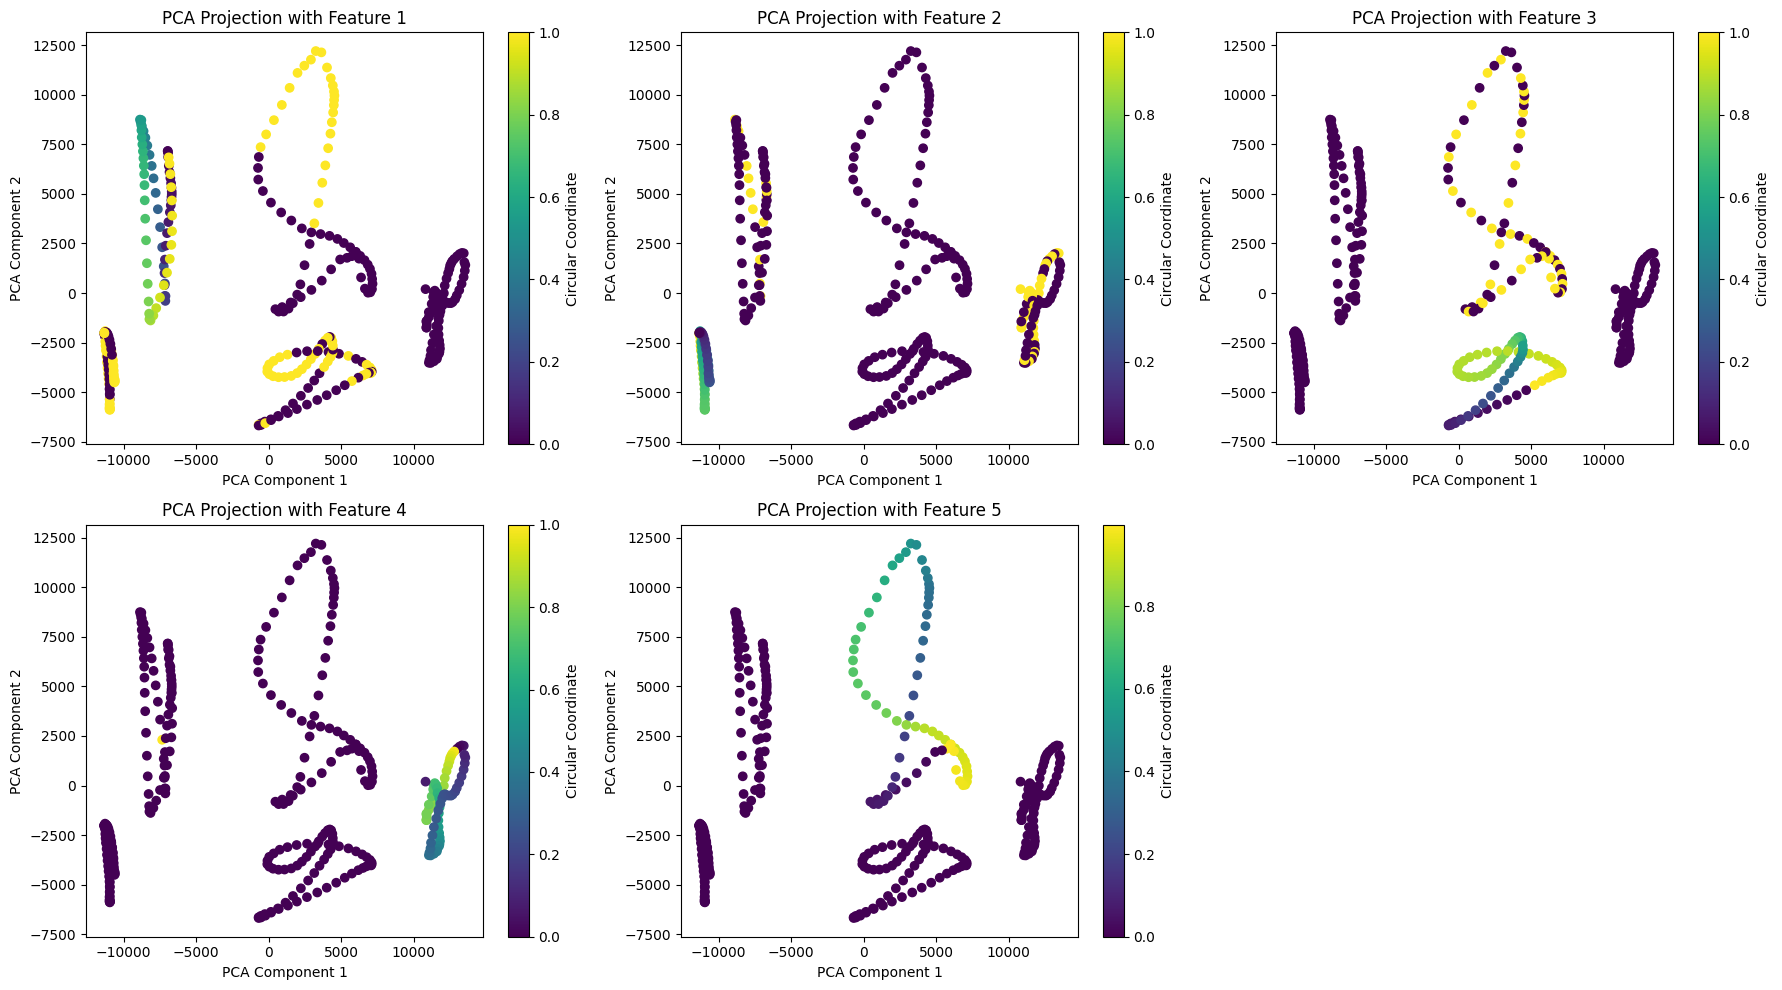

In [384]:
X_pca_all = PCA(n_components=2).fit_transform(X_img_all)

# Make scatter plots for each of the 5 circular coordinate features
circular_coords_list = [CC_1_img, CC_2_img, CC_3_img, CC_4_img, CC_5_img]

# Create a figure with 2 rows and 3 columns of subplots (last subplot will be unused)
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

# Plot each circular coordinate feature in a subplot
for i, cc_feature in enumerate(circular_coords_list):
    sc = axs[i].scatter(X_pca_all[:, 0], X_pca_all[:, 1], c=cc_feature, cmap='viridis')
    axs[i].set_xlabel('PCA Component 1')
    axs[i].set_ylabel('PCA Component 2')
    axs[i].set_title(f'PCA Projection with Feature {i+1}')
    fig.colorbar(sc, ax=axs[i], label='Circular Coordinate')

# Hide any extra subplots (if the grid has more subplots than features)
for j in range(len(circular_coords_list), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

As we can see, PCA is quite effective on separating the 5 different objects into clusters. Moreover, ploting the circular coordinates it is easy to see that the different holes are well identified by the different set of circular coordinates

# Some

In this section we are going to test our implementetion with two datasets. The first, a datset of shapes from openml.datasets, inspired by the images. The second, a synthetic dataset constructed by me.

Start by importing the datest that consist of pointclouds from real-world objects (from princeton course https://www.cs.princeton.edu/courses/archive/fall09/cos429/assignment3.html). The version we got through OpenML only has 40 models (4 classes 10 objects each)

In [353]:
df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]

now, the same way that we treate every image as a vector, we can make an array of entries where each entry is a point cloud:

In [354]:
point_clouds = np.asarray(
    [df.query("target == @shape")[["x", "y", "z"]].values for shape in df["target"].unique()]
)
print("Point clouds shape:", point_clouds.shape)

Point clouds shape: (40, 400, 3)


What I wanted to achieve, was an implementation that you give it any value (between 0 and 39), and it returns a 3d scatter plot that highlights the circular coordinates of the most persistent 1 dimension feature. It not only seems intuitive to better visualize the "holes" of the structure, but it is just the next step in the implementation.

First we define a function that calculates ripser and might plot it if you ask, it return diagrams[1], cocycles[1] and the distance matrix D.

In [355]:
def calculate_ripser(X, plot=False):
    """
    Run ripser on a point cloud X and return the 1D diagram, cocycles, and distance matrix.
    Optionally, plot the persistence diagram.
    """
    rips = ripser(X, do_cocycles=True)
    diagrams_pc = rips['dgms']
    cocycles_pc = rips['cocycles']
    D_pc = rips['dperm2all']
    if plot:
        diagram1_pc = diagrams_pc[1]
        idx_pc = np.argmax(diagram1_pc[:, 1] - diagram1_pc[:, 0])
        plot_diagrams(diagrams_pc, show=False)
        plt.scatter(diagram1_pc[idx_pc, 0], diagram1_pc[idx_pc, 1], 20, c='k', marker='x')
        plt.title("Point Cloud: Max 1D birth = %.3g, death = %.3g" % (diagram1_pc[idx_pc, 0], diagram1_pc[idx_pc, 1]))
        plt.show()
    return diagrams_pc[1], cocycles_pc[1], D_pc


Then we make a function that given a set of points, it gets a 3D plot with the circular coordinates

In [356]:
def plot_3d_circular_coordinates(X, D=False, cocycle=False, r=False, p=41, norm="linear", diagram=False):
    """
    Plot a 3D scatter of a point cloud X with points colored by their circular coordinate.
    If D is not provided, compute persistent homology using calculate_ripser().
    """
    if D is False:
        diagram1_pc, cocycles_pc, D = calculate_ripser(X, plot=diagram)
    coords_pc = circular_coordinates(D, cocycle, r, p)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=coords_pc, cmap="plasma", norm=norm)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

Now we can just set any number and it will plot the point cloud and its most representative circular coordinates:

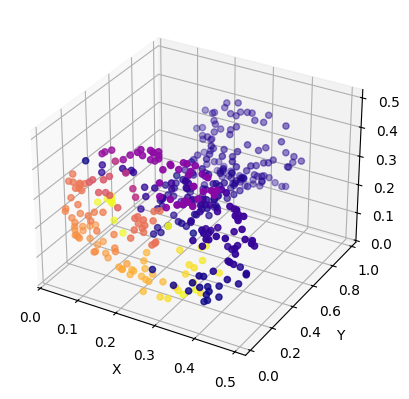

In [357]:
# Select a point cloud (change index from 0 to 39).
i_pc = 15
diagram1_pc, cocycles_pc, D_pc = calculate_ripser(point_clouds[i_pc])
max_idx_pc = np.argmax(diagram1_pc[:, 1] - diagram1_pc[:, 0])
# Plot 3D circular coordinates using the most persistent feature.
plot_3d_circular_coordinates(point_clouds[i_pc], r=diagram1_pc[max_idx_pc, 0] + 1e-5, diagram=False)

in here we can see one of the features of the circular coordinates: sometimes the most persistent feature is not centric to the pointcloud. This gives less information of the pointcloud overall but makes it really easy to identify the mots persistent feature. Some may say that this is a weakness but it is a good tool to get together with persistence homology to find this persistent features when looking back at the data and seeing what generates them.

## Flat Torus reconstruction with circular coordinates
The next implementation is going to be from the Flat Torus, but instead of just aplying circular coordinates again, we are going to use the circular coordinates to see that we can reconstruct the original position of the points in the surface of a flat torus by its circular coordinates. We start by remaking the flat torus: To better see that this preserves structure, we are going to poke some holes in the flat torus (small enough so that the most persistent features are still the 2 main holes)

We will start by defining the parameters for the grid and hole creation

In [475]:
grid_size = 16      # grid dimensions
num_holes = 4       # number of holes to create
min_samples = 15    # DBSCAN minimum samples per cluster
epsilon = 1         # DBSCAN epsilon
max_remove = 30     # maximum number of points to remove per cluster


continue by greating grid points and adding noise

In [476]:
t_vals = np.linspace(0, 1, grid_size)
x_grid, y_grid = np.meshgrid(t_vals, t_vals)
x_grid = x_grid.reshape(-1, 1)
y_grid = y_grid.reshape(-1, 1)

# Add noise to grid points
X_torus_all = np.hstack([x_grid, y_grid]) + 0.15 * np.random.random((grid_size**2, 2))

Continue by clustering with DBSCAN

In [477]:
# Create DBSCAN clustering model
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

# Fit the model and predict clusters
clusters = dbscan.fit_predict(X)

Group indices by cluster

In [478]:

# Identify points in clusterscluster_dict = {}
cluster_dict = {}
for idx, cl in enumerate(clusters):
    if cl != -1:
      if cl not in cluster_dict:
        cluster_dict[cluster_id] = []
      cluster_dict.setdefault(cl, []).append(idx)


Remove some points from cluster to form holes

In [479]:
holes_created = 0
for cl, indices in cluster_dict.items():
    if holes_created >= num_holes:
        break
    if len(indices) <= max_remove:
        X_torus_all[indices] = np.nan
    else:
        np.random.shuffle(indices)
        indices_to_remove = indices[:max_remove]
        X_torus_all[indices_to_remove] = np.nan
    holes_created += 1
# Remove NaN values
X_torus_all = X_torus_all[~np.isnan(X_torus_all).any(axis=1)]

Visualize the point cloud with holes

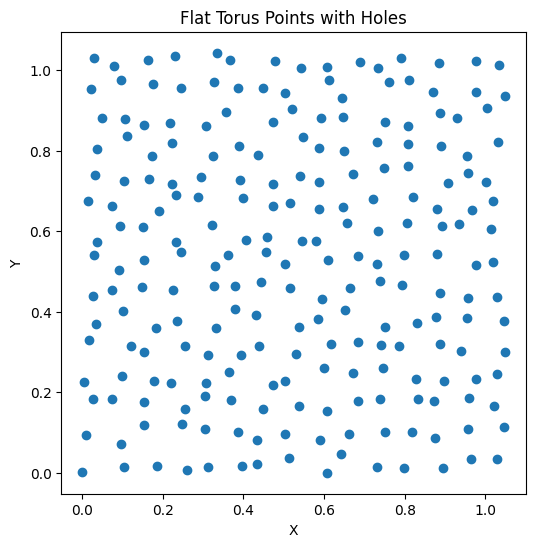

In [481]:
plt.figure(figsize=(6,6))
plt.scatter(X_torus[:,0], X_torus[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Flat Torus Points with Holes')
plt.show()

We calculate the distance matrix on the torus and run ripser on it

In [482]:
D_torus = torus_distance_matrix(X_torus_all)

# Run ripser on the torus distance matrix
torus_rips = ripser(D_torus, do_cocycles=True, distance_matrix=True, coeff=41)
diagrams_torus = torus_rips['dgms']
cocycles_torus = torus_rips['cocycles']
dgm1_torus = diagrams_torus[1]

we know plot the persistence diagram for the torus

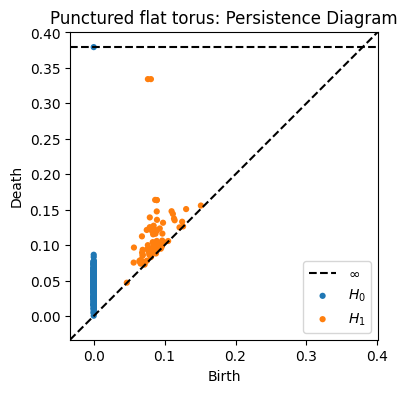

In [483]:
max_idx_torus = np.argmax(dgm1_torus[:, 1] - dgm1_torus[:, 0])
plt.figure(figsize=(6,4))
plot_diagrams(diagrams_torus, show=False)
plt.title("Punctured flat torus: Persistence Diagram")
plt.show()

And calculating the circulate coordinates of its two most persistent points

In [500]:
idx1_torus = np.argsort(dgm1_torus[:, 1] - dgm1_torus[:, 0], axis=0)[-1]
idx2_torus = np.argsort(dgm1_torus[:, 1] - dgm1_torus[:, 0], axis=0)[-2]
cocycle1_torus = cocycles_torus[1][idx1_torus]
cocycle2_torus = cocycles_torus[1][idx2_torus]

Now lets plot the flat torus using its default coordinates and its circular coordinates:

In [501]:
coordinates1_torus = circular_coordinates(D_torus, cocycle1_torus)
coordinates2_torus = circular_coordinates(D_torus, cocycle2_torus)


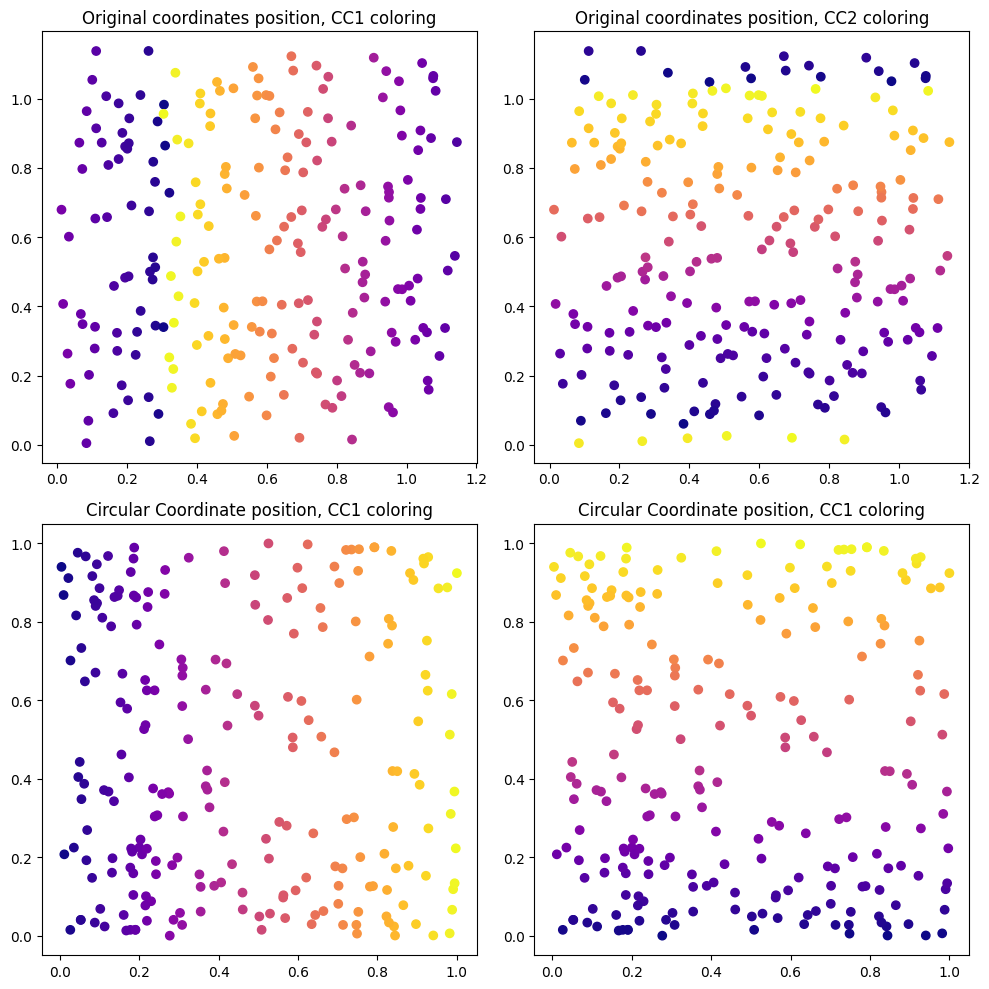

In [503]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first subplot
axs[0, 0].scatter(X_torus_all[:, 0], X_torus_all[:, 1], c=coordinates1_torus, cmap="plasma")
axs[0, 0].set_title('Original coordinates position, CC1 coloring')

# Plot the second subplot
axs[0, 1].scatter(X_torus_all[:, 0], X_torus_all[:, 1], c=coordinates2_torus, cmap="plasma")
axs[0, 1].set_title('Original coordinates position, CC2 coloring')

# Plot the third subplot
axs[1, 0].scatter(coordinates1_torus[:], coordinates2_torus[:], c=coordinates1_torus, cmap="plasma")
axs[1, 0].set_title('Circular Coordinate position, CC1 coloring')

# Plot the fourth subplot
axs[1, 1].scatter(coordinates1_torus[:], coordinates2_torus[:], c=coordinates2_torus, cmap="plasma")
axs[1, 1].set_title('Circular Coordinate position, CC1 coloring')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()



With this, what it should be noticed is that, even if  swapping axis, or directions (and on the unfortunate case that one of the two circular coordinates is diagonal a little of tilting), most of the torus structure is preserved.

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
